In [7]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# SVM
from sklearn import svm
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Data Preparation


Prepare the data to be used with kNN

In [8]:
plots = [("traces/normal/", 'grid9_normal_2019-02-13_17:05'),
         ("traces/1bh-3/", 'grid9_1bh-3_2019-02-13_16:28'),
         ("traces/1bh-5/", 'grid9_1bh-5_2019-02-13_15:31'),
         ("traces/1bh-6/", 'grid9_1bh-6_2019-02-13_12:59'),
         ("traces/1bh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1bh-9/", 'grid9_1bh-9_2019-02-13_15:57'),
         ("traces/1gh-3/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-5/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-6/", 'grid_1gh-6_2019-02-15_18:25'),
         ("traces/1gh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1gh-9/", 'grid_1gh-9_2019-02-15_19:19')
        ]

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[0].split('/')[1]
    
    # Assign a label
    if row[0].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[0].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,label
0,aaaa::212:7404:4:404:,normal,141,339.276596,85174.044377,291.845926,2,106.0,1563.0,0.295,Normal
1,aaaa::212:7405:5:505:,normal,178,392.123596,28083.058084,167.580005,3,197.0,1557.0,0.110,Normal
2,aaaa::212:7407:7:707:,normal,151,486.913907,68843.959205,262.381324,3,214.0,1623.0,0.245,Normal
3,aaaa::212:7406:6:606:,normal,176,315.613636,40342.752727,200.855054,2,129.0,1144.0,0.120,Normal
4,aaaa::212:740a:a:a0a:,normal,181,497.646409,66065.140945,257.031401,4,260.0,1945.0,0.095,Normal


Select the set of features and labels that we use to fit the algorithm

In [12]:
# separate features from target values
features = stats.drop(columns=['node_id', 'experiment', 'hop', 'label'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Gray Hole', 'Normal', 'Black Hole'}


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

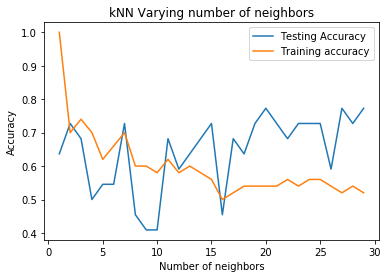

In [13]:
trace_analysis.knn_test_number_of_neighbors(X_train, X_test, y_train, y_test)

Let's build KNN classifier 

In [ ]:
results = None

for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'hop', 'label'])
    target = trace['label'].values
    
    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
     
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=30)

    #Train the model using the training sets
    knn.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = knn.predict(X_test)
    
    # Add results to a Dataframe
    if results is None:
        results = pd.DataFrame({'Model': ['KNN'], 
                                'Window Size': [trace_size], 
                                'Accuracy': [metrics.accuracy_score(y_test, y_pred)],
                                'Precision': [metrics.precision_score(y_test, y_pred, average='macro')], 
                                'Recall': [metrics.recall_score(y_test, y_pred, average='macro')], 
                                'F1-score': [metrics.f1_score(y_test, y_pred, average='macro')]})
    else:
        results = pd.concat([results,pd.DataFrame({'Model': ['KNN'], 
                                                         'Window Size': [trace_size], 
                                                         'Accuracy': [metrics.accuracy_score(y_test, y_pred)],
                                                         'Precision': [metrics.precision_score(y_test, y_pred, average='macro')], 
                                                         'Recall': [metrics.recall_score(y_test, y_pred, average='macro')], 
                                                         'F1-score': [metrics.f1_score(y_test, y_pred, average='macro')]})])


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [12]:
cv_results = None

# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label'])
    target = trace['label'].values
    
    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create KNN Classifier
    knn_clf = KNeighborsClassifier(n_neighbors=29)
    
    #train model with cv of 5
    cv_scores = cross_val_score(knn_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['KNN'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['KNN'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [57]:
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'hop', 'label'])
    target = trace['label'].values
    
    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
     
    #Create a svm Classifier
    svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel

    #Train the model using the training sets
    svm_clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = svm_clf.predict(X_test)
    
    # Add results to a Dataframe
    if results is None:
        results = pd.DataFrame({'Model': ['SVM'], 
                                'Window Size': [trace_size], 
                                'Accuracy': [metrics.accuracy_score(y_test, y_pred)],
                                'Precision': [metrics.precision_score(y_test, y_pred, average='macro')], 
                                'Recall': [metrics.recall_score(y_test, y_pred, average='macro')], 
                                'F1-score': [metrics.f1_score(y_test, y_pred, average='macro')]})
    else:
        results = pd.concat([results,pd.DataFrame({'Model': ['SVM'], 
                                                         'Window Size': [trace_size], 
                                                         'Accuracy': [metrics.accuracy_score(y_test, y_pred)],
                                                         'Precision': [metrics.precision_score(y_test, y_pred, average='macro')], 
                                                         'Recall': [metrics.recall_score(y_test, y_pred, average='macro')], 
                                                         'F1-score': [metrics.f1_score(y_test, y_pred, average='macro')]})])


Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [13]:
# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label'])
    target = trace['label'].values
    
    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create SVM Classifier
    svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel
    
    #train model with cv of 5
    cv_scores = cross_val_score(svm_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['SVM'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['SVM'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

No handles with labels found to put in legend.


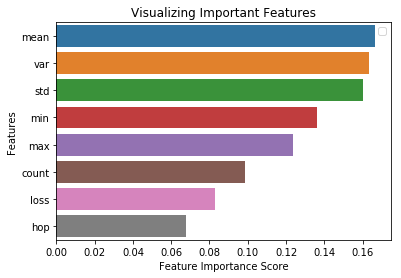

In [8]:
trace_analysis.random_forests_features_selection(X_train, X_test, y_train, y_test, features)

Predicted values

In [58]:
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    
    # separate features from target values
    features = stats.drop(columns=['node_id', 'experiment', 'label', 'hop','loss'])
    target = stats['label'].values
    print('Targets: ' + str(set(target)))

    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
     
    #Create a Gaussian Classifier
    rf_clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    rf_clf.fit(X_train,y_train)

    y_pred = rf_clf.predict(X_test)
    
    # Add results to a Dataframe
    if results is None:
        results = pd.DataFrame({'Model': ['Random Forest'], 
                                'Window Size': [trace_size], 
                                'Accuracy': [metrics.accuracy_score(y_test, y_pred)],
                                'Precision': [metrics.precision_score(y_test, y_pred, average='macro')], 
                                'Recall': [metrics.recall_score(y_test, y_pred, average='macro')], 
                                'F1-score': [metrics.f1_score(y_test, y_pred, average='macro')]})
    else:
        results = pd.concat([results,pd.DataFrame({'Model': ['Random Forest'], 
                                                         'Window Size': [trace_size], 
                                                         'Accuracy': [metrics.accuracy_score(y_test, y_pred)],
                                                         'Precision': [metrics.precision_score(y_test, y_pred, average='macro')], 
                                                         'Recall': [metrics.recall_score(y_test, y_pred, average='macro')], 
                                                         'F1-score': [metrics.f1_score(y_test, y_pred, average='macro')]})])


Computing trace 200
Targets: {'Gray Hole', 'Normal', 'Black Hole'}
Computing trace 25
Targets: {'Gray Hole', 'Normal', 'Black Hole'}
Computing trace 50
Targets: {'Gray Hole', 'Normal', 'Black Hole'}
Computing trace 100
Targets: {'Gray Hole', 'Normal', 'Black Hole'}


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [19]:
# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label', 'hop'])
    target = trace['label'].values
    print('Targets: ' + str(set(target)))

    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100)
    
    #train model with cv of 5
    cv_scores = cross_val_score(rf_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['Random Forest'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['Random Forest'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Targets: {'Gray Hole', 'Normal', 'Black Hole'}
Computing trace 25
Targets: {'Gray Hole', 'Normal', 'Black Hole'}
Computing trace 50
Targets: {'Gray Hole', 'Normal', 'Black Hole'}
Computing trace 100
Targets: {'Gray Hole', 'Normal', 'Black Hole'}


# Results

Results for each model

In [59]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score
0,KNN,200,0.772727,0.516667,0.542424,0.526696
1,KNN,25,0.509554,0.491285,0.452554,0.424236
2,KNN,50,0.487805,0.487575,0.435870,0.450082
3,KNN,100,0.604651,0.403704,0.456439,0.428452
4,SVM,200,0.863636,0.765993,0.903030,0.805954
5,SVM,25,0.535032,0.515491,0.582482,0.537633
6,SVM,50,0.463415,0.454545,0.485654,0.465618
7,SVM,100,0.604651,0.593074,0.645455,0.612121
8,Random Forest,200,0.636364,0.746795,0.742424,0.740741
9,Random Forest,25,0.727273,0.814103,0.806061,0.805556


Here we plot the average results for each model

In [55]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,KNN,200,0.572454
1,KNN,25,0.531777
2,KNN,50,0.548017
3,KNN,100,0.584647
4,SVM,200,0.665604
5,SVM,25,0.644291
6,SVM,50,0.669661
7,SVM,100,0.726712
8,Random Forest,200,0.615458
9,Random Forest,25,0.575718
